### Convert GPS latitude and longitude to local tangent plane

In [3]:
# transformation code taken from: https://github.com/geospace-code/pymap3d

In [82]:
from typing import Tuple, Union
from numpy import (
        ndarray,
        asarray,
        radians,
        sin,
        cos,
        tan,
        arctan as atan,
        hypot,
        degrees,
        arctan2 as atan2,
        sqrt,
        pi,
    )

In [83]:
"""Minimal class for planetary ellipsoids"""
from math import sqrt


class Ellipsoid:
    """
    generate reference ellipsoid parameters
    https://en.wikibooks.org/wiki/PROJ.4#Spheroid
    https://nssdc.gsfc.nasa.gov/planetary/factsheet/index.html
    as everywhere else in this program, distance units are METERS
    """

    def __init__(self, model: str = "wgs84"):
        """
        feel free to suggest additional ellipsoids
        Parameters
        ----------
        model : str
                name of ellipsoid
        """

        if model == "wgs84":
            """https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84"""
            self.semimajor_axis = 6378137.0
            self.semiminor_axis = 6356752.31424518
        elif model == "wgs72":
            self.semimajor_axis = 6378135.0
            self.semiminor_axis = 6356750.52001609
        elif model == "grs80":
            """https://en.wikipedia.org/wiki/GRS_80"""
            self.semimajor_axis = 6378137.0
            self.semiminor_axis = 6356752.31414036
        elif model == "clarke1866":
            self.semimajor_axis = 6378206.4
            self.semiminor_axis = 6356583.8
        elif model == "mars":
            """
            https://tharsis.gsfc.nasa.gov/geodesy.html
            """
            self.semimajor_axis = 3396900.0
            self.semiminor_axis = 3376097.80585952
        elif model == "moon":
            self.semimajor_axis = 1738000.0
            self.semiminor_axis = self.semimajor_axis
        elif model == "venus":
            self.semimajor_axis = 6051000.0
            self.semiminor_axis = self.semimajor_axis
        elif model == "jupiter":
            self.semimajor_axis = 71492000.0
            self.semiminor_axis = 66770054.3475922
        elif model == "io":
            """
            https://doi.org/10.1006/icar.1998.5987
            """
            self.semimajor_axis = 1829.7
            self.semiminor_axis = 1815.8
        elif model == "pluto":
            self.semimajor_axis = 1187000.0
            self.semiminor_axis = self.semimajor_axis
        else:
            raise NotImplementedError(
                f"{model} model not implemented, let us know and we will add it (or make a pull request)"
            )

        self.flattening = (self.semimajor_axis - self.semiminor_axis) / self.semimajor_axis
        self.thirdflattening = (self.semimajor_axis - self.semiminor_axis) / (
            self.semimajor_axis + self.semiminor_axis
        )
        self.eccentricity = sqrt(2 * self.flattening - self.flattening ** 2)

In [84]:
def sanitize(lat: Union[float, ndarray], ell: Ellipsoid, deg: bool) -> Tuple[Union[float, ndarray], Ellipsoid]:
    if ell is None:
        ell = Ellipsoid()
    if asarray is not None:
        lat = asarray(lat)
    if deg:
        lat = radians(lat)

    if asarray is not None:
        if (abs(lat) > pi / 2).any():
            raise ValueError("-pi/2 <= latitude <= pi/2")
    else:
        if abs(lat) > pi / 2:
            raise ValueError("-pi/2 <= latitude <= pi/2")

    return lat, ell

In [85]:
def geodetic2ecef(
    lat: ndarray,
    lon: ndarray,
    alt: ndarray,
    ell: Ellipsoid = None,
    deg: bool = True,
) -> Tuple[ndarray, ndarray, ndarray]:
    """
    point transformation from Geodetic of specified ellipsoid (default WGS-84) to ECEF
    Parameters
    ----------
    lat : float
           target geodetic latitude
    lon : float
           target geodetic longitude
    h : float
         target altitude above geodetic ellipsoid (meters)
    ell : Ellipsoid, optional
          reference ellipsoid
    deg : bool, optional
          degrees input/output  (False: radians in/out)
    Returns
    -------
    ECEF (Earth centered, Earth fixed)  x,y,z
    x : float
        target x ECEF coordinate (meters)
    y : float
        target y ECEF coordinate (meters)
    z : float
        target z ECEF coordinate (meters)
    """
    lat, ell = sanitize(lat, ell, deg)
    if deg:
        lon = radians(lon)

    # radius of curvature of the prime vertical section
    N = ell.semimajor_axis ** 2 / sqrt(
        ell.semimajor_axis ** 2 * cos(lat) ** 2 + ell.semiminor_axis ** 2 * sin(lat) ** 2
    )
    # Compute cartesian (geocentric) coordinates given  (curvilinear) geodetic
    # coordinates.
    x = (N + alt) * cos(lat) * cos(lon)
    y = (N + alt) * cos(lat) * sin(lon)
    z = (N * (ell.semiminor_axis / ell.semimajor_axis) ** 2 + alt) * sin(lat)

    return x, y, z


def ecef2geodetic(
    x: ndarray,
    y: ndarray,
    z: ndarray,
    ell: Ellipsoid = None,
    deg: bool = True,
) -> Tuple[ndarray, ndarray, ndarray]:
    """
    convert ECEF (meters) to geodetic coordinates
    Parameters
    ----------
    x : float
        target x ECEF coordinate (meters)
    y : float
        target y ECEF coordinate (meters)
    z : float
        target z ECEF coordinate (meters)
    ell : Ellipsoid, optional
          reference ellipsoid
    deg : bool, optional
          degrees input/output  (False: radians in/out)
    Returns
    -------
    lat : float
           target geodetic latitude
    lon : float
           target geodetic longitude
    alt : float
         target altitude above geodetic ellipsoid (meters)
    based on:
    You, Rey-Jer. (2000). Transformation of Cartesian to Geodetic Coordinates without Iterations.
    Journal of Surveying Engineering. doi: 10.1061/(ASCE)0733-9453
    """

    if ell is None:
        ell = Ellipsoid()

    r = sqrt(x ** 2 + y ** 2 + z ** 2)

    E = sqrt(ell.semimajor_axis ** 2 - ell.semiminor_axis ** 2)

    # eqn. 4a
    u = sqrt(0.5 * (r ** 2 - E ** 2) + 0.5 * sqrt((r ** 2 - E ** 2) ** 2 + 4 * E ** 2 * z ** 2))

    Q = hypot(x, y)

    huE = hypot(u, E)

    # eqn. 4b
    try:
        Beta = atan(huE / u * z / hypot(x, y))
    except ZeroDivisionError:
        if z >= 0:
            Beta = pi / 2
        else:
            Beta = -pi / 2

    # eqn. 13
    eps = ((ell.semiminor_axis * u - ell.semimajor_axis * huE + E ** 2) * sin(Beta)) / (
        ell.semimajor_axis * huE * 1 / cos(Beta) - E ** 2 * cos(Beta)
    )

    Beta += eps
    # %% final output
    lat = atan(ell.semimajor_axis / ell.semiminor_axis * tan(Beta))

    lon = atan2(y, x)

    # eqn. 7
    alt = hypot(z - ell.semiminor_axis * sin(Beta), Q - ell.semimajor_axis * cos(Beta))

    # inside ellipsoid?
    inside = (
        x ** 2 / ell.semimajor_axis ** 2
        + y ** 2 / ell.semimajor_axis ** 2
        + z ** 2 / ell.semiminor_axis ** 2
        < 1
    )

    try:
        if inside.any():  # type: ignore
            # avoid all false assignment bug
            alt[inside] = -alt[inside]
    except (TypeError, AttributeError):
        if inside:
            alt = -alt

    if deg:
        lat = degrees(lat)
        lon = degrees(lon)

    return lat, lon, alt

In [86]:
def uvw2enu(
    u: ndarray, v: ndarray, w: ndarray, lat0: ndarray, lon0: ndarray, deg: bool = True
) -> Tuple[ndarray, ndarray, ndarray]:
    """
    Parameters
    ----------
    u : float
    v : float
    w : float
    Results
    -------
    East : float
        target east ENU coordinate (meters)
    North : float
        target north ENU coordinate (meters)
    Up : float
        target up ENU coordinate (meters)
    """
    if deg:
        lat0 = radians(lat0)
        lon0 = radians(lon0)

    t = cos(lon0) * u + sin(lon0) * v
    East = -sin(lon0) * u + cos(lon0) * v
    Up = cos(lat0) * t + sin(lat0) * w
    North = -sin(lat0) * t + cos(lat0) * w

    return East, North, Up


def enu2uvw(
    east: ndarray,
    north: ndarray,
    up: ndarray,
    lat0: ndarray,
    lon0: ndarray,
    deg: bool = True,
) -> Tuple[ndarray, ndarray, ndarray]:
    """
    Parameters
    ----------
    e1 : float
        target east ENU coordinate (meters)
    n1 : float
        target north ENU coordinate (meters)
    u1 : float
        target up ENU coordinate (meters)
    Results
    -------
    u : float
    v : float
    w : float
    """

    if deg:
        lat0 = radians(lat0)
        lon0 = radians(lon0)

    t = cos(lat0) * up - sin(lat0) * north
    w = sin(lat0) * up + cos(lat0) * north

    u = cos(lon0) * t - sin(lon0) * east
    v = sin(lon0) * t + cos(lon0) * east

    return u, v, w

In [87]:
def geodetic2enu(
    lat: ndarray,
    lon: ndarray,
    h: ndarray,
    lat0: ndarray,
    lon0: ndarray,
    h0: ndarray,
    ell: Ellipsoid = None,
    deg: bool = True,
) -> Tuple[ndarray, ndarray, ndarray]:
    """
    Parameters
    ----------
    lat : float
          target geodetic latitude
    lon : float
          target geodetic longitude
    h : float
          target altitude above ellipsoid  (meters)
    lat0 : float
           Observer geodetic latitude
    lon0 : float
           Observer geodetic longitude
    h0 : float
         observer altitude above geodetic ellipsoid (meters)
    ell : Ellipsoid, optional
          reference ellipsoid
    deg : bool, optional
          degrees input/output  (False: radians in/out)
    Results
    -------
    e : float
        East ENU
    n : float
        North ENU
    u : float
        Up ENU
    """
    x1, y1, z1 = geodetic2ecef(lat, lon, h, ell, deg=deg)
    x2, y2, z2 = geodetic2ecef(lat0, lon0, h0, ell, deg=deg)

    return uvw2enu(x1 - x2, y1 - y2, z1 - z2, lat0, lon0, deg=deg)


def enu2ecef(
    e1: ndarray,
    n1: ndarray,
    u1: ndarray,
    lat0: ndarray,
    lon0: ndarray,
    h0: ndarray,
    ell: Ellipsoid = None,
    deg: bool = True,
) -> Tuple[ndarray, ndarray, ndarray]:
    """
    ENU to ECEF
    Parameters
    ----------
    e1 : float
        target east ENU coordinate (meters)
    n1 : float
        target north ENU coordinate (meters)
    u1 : float
        target up ENU coordinate (meters)
    lat0 : float
        Observer geodetic latitude
    lon0 : float
        Observer geodetic longitude
    h0 : float
         observer altitude above geodetic ellipsoid (meters)
    ell : Ellipsoid, optional
          reference ellipsoid
    deg : bool, optional
          degrees input/output  (False: radians in/out)
    Results
    -------
    x : float
        target x ECEF coordinate (meters)
    y : float
        target y ECEF coordinate (meters)
    z : float
        target z ECEF coordinate (meters)
    """
    x0, y0, z0 = geodetic2ecef(lat0, lon0, h0, ell, deg=deg)
    dx, dy, dz = enu2uvw(e1, n1, u1, lat0, lon0, deg=deg)

    return x0 + dx, y0 + dy, z0 + dz


def enu2geodetic(
    e: ndarray,
    n: ndarray,
    u: ndarray,
    lat0: ndarray,
    lon0: ndarray,
    h0: ndarray,
    ell: Ellipsoid = None,
    deg: bool = True,
) -> Tuple[ndarray, ndarray, ndarray]:
    """
    East, North, Up to target to geodetic coordinates
    Parameters
    ----------
    e : float
        East ENU coordinate (meters)
    n : float
        North ENU coordinate (meters)
    u : float
        Up ENU coordinate (meters)
    lat0 : float
           Observer geodetic latitude
    lon0 : float
           Observer geodetic longitude
    h0 : float
         observer altitude above geodetic ellipsoid (meters)
    ell : Ellipsoid, optional
          reference ellipsoid
    deg : bool, optional
          degrees input/output  (False: radians in/out)
    Results
    -------
    lat : float
          geodetic latitude
    lon : float
          geodetic longitude
    alt : float
          altitude above ellipsoid  (meters)
    """

    x, y, z = enu2ecef(e, n, u, lat0, lon0, h0, ell, deg=deg)

    return ecef2geodetic(x, y, z, ell, deg=deg)

### Convert GPS readings to LTP with origin at first keyframe location

In [88]:
import pickle
import json
import numpy as np

import sys
sys.path.append("..")

In [89]:
def gps_to_ltp(gps):
    """Converts GPS readings from WGS-84 (lat, lon, height) to local tangent plane. 
    The first gps reading is choosen as origin.
    """
    # pick GPS position of keyframe 0 as origin of LTP
    lon0, lat0, h0 = gps[0, :]
    print("Origin of local tangent plane: lat: {}° -- long: {}° -- height: {} m".format(lat0, lon0, h0))
    # transform all other GPS positions into LTP
    gps_ltp = np.zeros_like(gps)
    for i, (lon, lat, h) in enumerate(gps):
        e, n, u = geodetic2enu(lat, lon, h, lat0, lon0, h0)
        gps_ltp[i, :] = np.array([e, n, u])
    return gps_ltp

In [90]:
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
#map_points = pickle.load(open("map_points.pkl", "rb"))
gps_file = "../data_processing/splitted/gps/gps.json"
gps_ = json.load(open(gps_file, "r"))

gps = np.zeros((len(gps_), 3))
gps[:, 0:2] = np.array(gps_)

gps = gps_to_ltp(gps)

Origin of local tangent plane: lat: 49.32741555555556° -- long: 10.519741944444446° -- height: 0.0 m


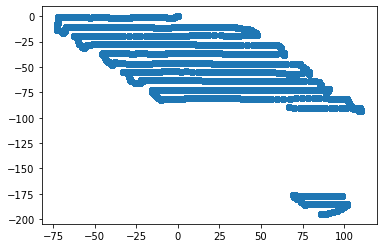

In [91]:
import matplotlib.pyplot as plt

plt.scatter(gps[:, 0], gps[:, 1])
plt.show()

In [104]:
pickle.dump(gps, open("gps.pkl", "wb"))